In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [21]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [22]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
               'ship', 'truck']

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [24]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

tf.Tensor([6], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([4], shape=(1,), dtype=uint8)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([1], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([8], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([4], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([7], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([9], shape=(1,), dtype=uint8)
tf.Tensor([3], shape=(1,), dtype=uint8)
tf.Tensor([2], shape=(1,), dtype=uint8)
tf.Tensor([6], shape=(1,), dtype=uint8)


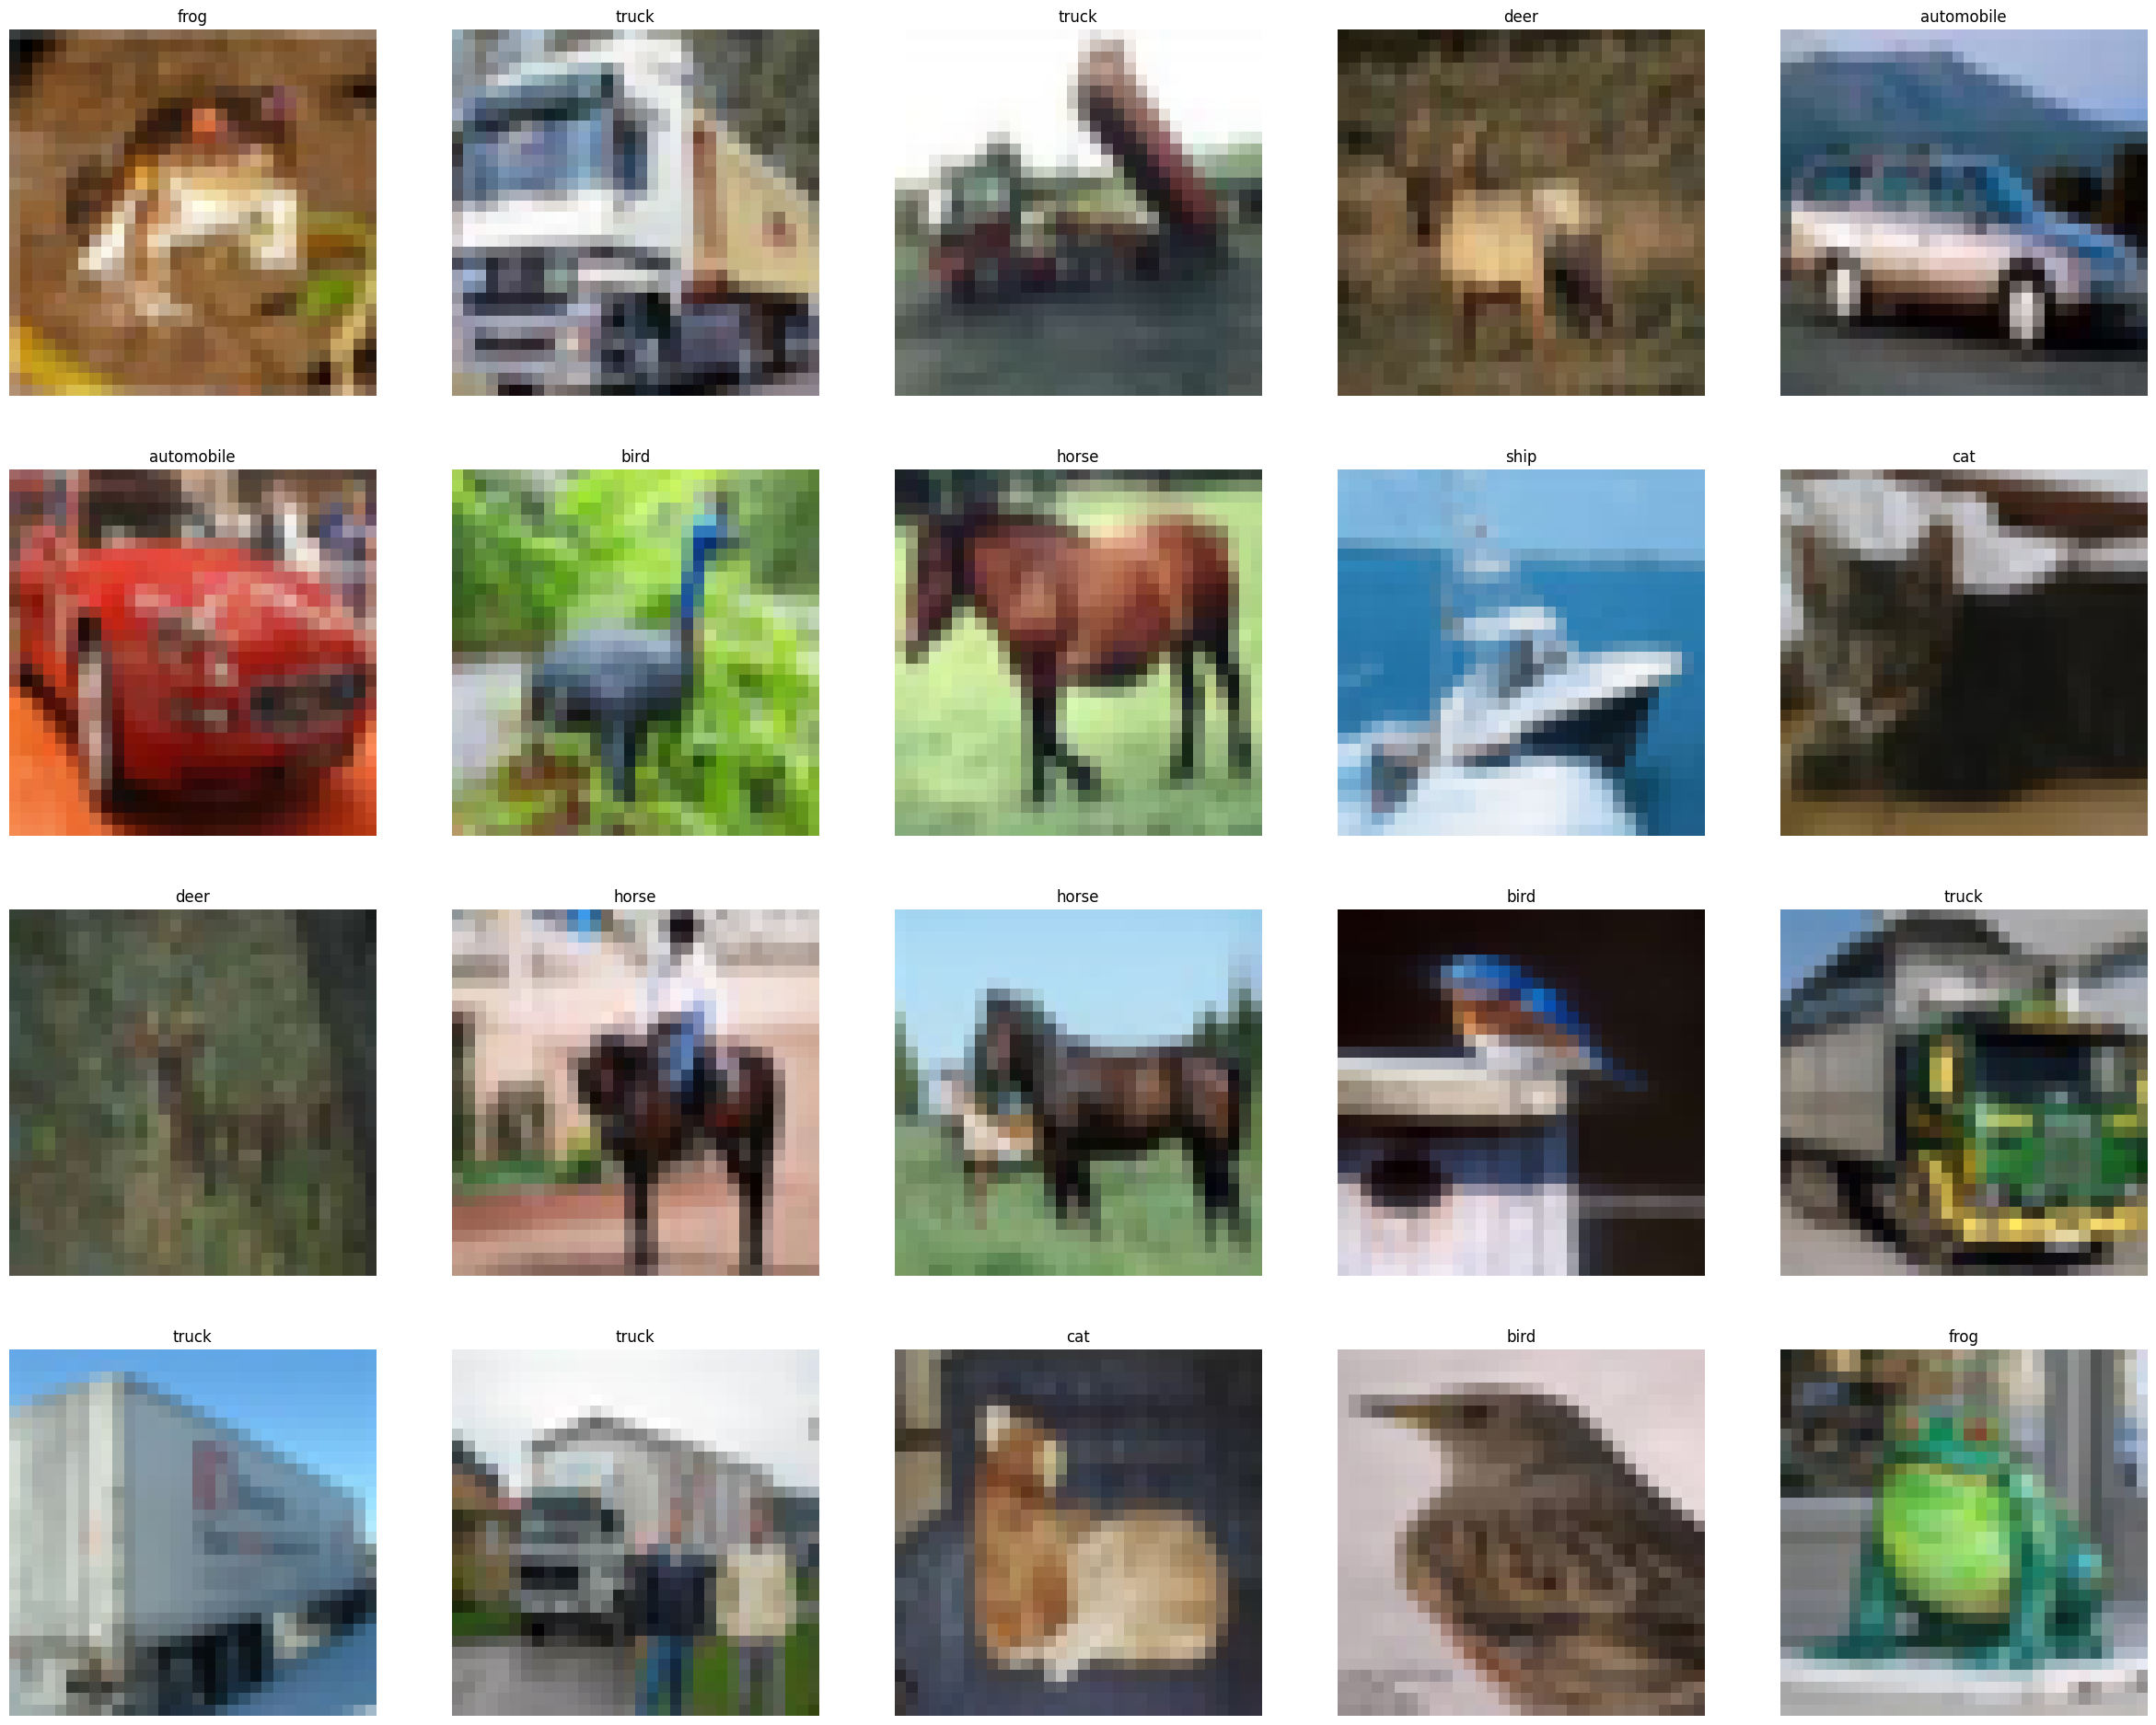

In [25]:
plt.figure(figsize=(30,30))
for i, (image, label) in enumerate(train_ds.take(20)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    print(label)
    plt.axis('off')

In [26]:
for i, (image, label) in enumerate(train_ds.take(20)):
    #print(image)
    print(tf.image.per_image_standardization(image))

tf.Tensor(
[[[-0.85518736 -0.79746586 -0.77822536]
  [-1.1630353  -1.1053138  -1.1245543 ]
  [-1.0283518  -1.0668328  -1.1630353 ]
  ...
  [ 1.0496216   0.54936874  0.08759686]
  [ 0.9341786   0.41468525 -0.02784611]
  [ 0.85721666  0.39544478 -0.00860561]]

 [[-1.6825286  -1.6055666  -1.6055666 ]
  [-1.9903765  -1.9903765  -1.9903765 ]
  [-1.6440476  -1.8364526  -1.9903765 ]
  ...
  [ 0.37620428 -0.29721302 -0.93214935]
  [ 0.2992423  -0.3934155  -1.0283518 ]
  [ 0.35696378 -0.31645352 -0.89366835]]

 [[-1.5093641  -1.5286046  -1.5863261 ]
  [-1.6825286  -1.8556931  -1.9903765 ]
  [-1.0475923  -1.4708831  -1.8364526 ]
  ...
  [ 0.2800018  -0.374175   -1.0283518 ]
  [ 0.3184828  -0.374175   -1.0283518 ]
  [ 0.10683735 -0.58582044 -1.1822758 ]]

 ...

 [[ 2.0116463   1.2805076  -0.14328907]
  [ 1.8769628   0.9534191  -1.3361998 ]
  [ 1.8192414   1.1073431  -1.4901236 ]
  ...
  [ 1.0881026   0.56860924 -0.64354193]
  [-0.91290885 -1.3939213  -1.8556931 ]
  [-0.97063035 -1.3361998  -1.605

In [27]:
def process_image(image, label):
    image = tf.image.per_image_standardization(image)
    # 이미지를 평균 0, 분산 1인 값으로 정규화 해줌
    image = tf.image.resize(image, (227,227))
    return image, label

In [28]:
# Data pipeline

# 데이터 갯수 반환
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()

print(train_ds_size)
print(test_ds_size)

50000
10000


In [29]:
train_ds = (train_ds
            .map(process_image) # 데이터셋 내의 각각의 이미지들에 동일한 함수를 적용
            .shuffle(buffer_size=train_ds_size) # 버퍼에 버퍼 사이즈만큼의 데이터를 넣고 섞음 
            .batch(batch_size=32, drop_remainder=True)
            )
# shuffle의 buffer_size: 데이터 크기 이상의 buffer_size를 사용해야 제대로 shuffle이 됨
# batch의 drop_remainder: 배치를 만들고 남은 데이터를 버릴것인지 여부

test_ds = (test_ds
           .map(process_image)
           .shuffle(buffer_size=test_ds_size)
           .batch(batch_size=32, drop_remainder=True)
           )

In [33]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(227,227,3)))
# padding - valid: 패딩을 사용하지 않음(0px), 

# Conv-1
model.add(tf.keras.layers.Conv2D(96, 11, strides=4, padding='valid'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.Activation('relu'))

# MaxPool-1
model.add(tf.keras.layers.MaxPool2D(3, strides=2))

# Conv-2
model.add(tf.keras.layers.Conv2D(256, 5, strides=1, padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.Activation('relu'))

# MaxPool-2
model.add(tf.keras.layers.MaxPool2D(3, strides=2))

# Conv-3
model.add(tf.keras.layers.Conv2D(384, 3, strides=1, padding='same'))
model.add(tf.keras.layers.Activation('relu'))

# Conv-4
model.add(tf.keras.layers.Conv2D(384, 3, strides=1, padding='same'))
model.add(tf.keras.layers.Activation('relu'))

# Conv-5
model.add(tf.keras.layers.Conv2D(256, 3, strides=1, padding='same'))
model.add(tf.keras.layers.Activation('relu'))

# MaxPool-3
model.add(tf.keras.layers.MaxPool2D(3, strides=2))

model.add(tf.keras.layers.Flatten())

# fc-1
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# fc-2
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# fc-3 
#model.add(tf.keras.layers.Dense(1000, activation='softmax'))
# 원래 논문에서는 ImageNet의 클래스가 1000개이기 때문에 1000개의 뉴런을 가진 fc layer를 사용해야 하지만
# 테스트할 데이터의 클래스가 10개이기 때문에 10개의 뉴런을 가진 fc layer를 사용
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 lambda_5 (Lambda)           (None, 55, 55, 96)        0         
                                                                 
 activation_11 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 lambda_6 (Lambda)           (None, 27, 27, 256)       0         
                                                      

In [34]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/10
1562/1562 [==============================] - 204s 106ms/step - loss: 1.9420 - accuracy: 0.3185 - val_loss: 1.3918 - val_accuracy: 0.4933
Epoch 2/10
1562/1562 [==============================] - 198s 114ms/step - loss: 1.2131 - accuracy: 0.5687 - val_loss: 1.0156 - val_accuracy: 0.6441
Epoch 3/10
1562/1562 [==============================] - 198s 114ms/step - loss: 0.9354 - accuracy: 0.6709 - val_loss: 0.8313 - val_accuracy: 0.7131
Epoch 4/10
1562/1562 [==============================] - 196s 114ms/step - loss: 0.7602 - accuracy: 0.7358 - val_loss: 0.7806 - val_accuracy: 0.7270
Epoch 5/10
1562/1562 [==============================] - 194s 113ms/step - loss: 0.6239 - accuracy: 0.7823 - val_loss: 0.7377 - val_accuracy: 0.7490
Epoch 6/10
1562/1562 [==============================] - 197s 114ms/step - loss: 0.5162 - accuracy: 0.8208 - val_loss: 0.6798 - val_accuracy: 0.7719
Epoch 7/10
1562/1562 [==============================] - 194s 113ms/step - loss: 0.4178 - accuracy: 0.8536 - val_

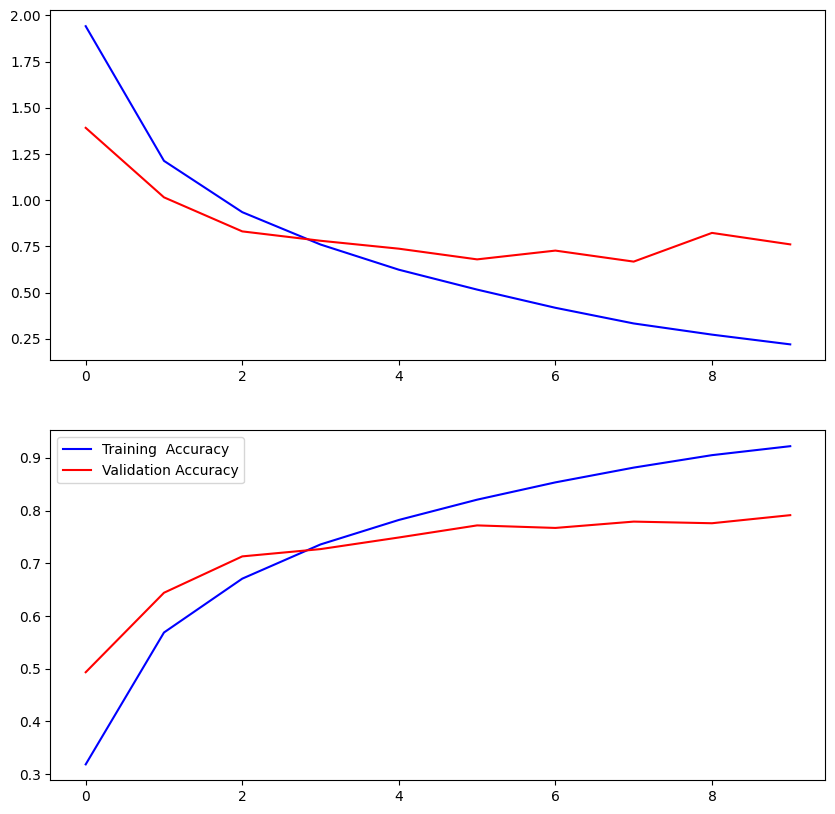

In [36]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [ ]:
# 논문: https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
# 참고: https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner
# 참고: https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8